![alt](https://research.utm.my/wp-content/uploads/sites/26/2022/06/logo-300x122.png)
# Center for Artificial Intelligence and Robotics
#### Universiti Teknologi Malaysia


### Detection Training - FasterRCNN

*Author: Dr. Ibrahim, Azzam, Thaqif & Syahmi*

**FasterRCNN for object detection.**

_ | _

## Set Up Data Directory

In this section, we ensure that the data is stored in the correct directory within the JupyterHub environment. The script checks if the specified data path exists, and if not, it creates the necessary directory structure.

In [1]:
# Ensure data is available in the correct location for JupyterHub
import os
data_path = '___' # FIX ME
if not os.path.exists(data_path):
    os.makedirs(data_path)

## Import Required Libraries

In this section, we import all the necessary libraries and modules that will be used throughout the project, including:
- **Standard Libraries**: Such as `os`, `copy`, `math`, and `warnings`.
- **Numerical and Data Handling Libraries**: `numpy` and `pandas`.
- **PyTorch and TorchVision**: Core libraries for building and training deep learning models, including utility functions and datasets.
- **Image Processing and Augmentation**: `albumentations` for augmentations, `cv2` for OpenCV operations, and `matplotlib.pyplot` for visualizations.
- **Utilities**: `tqdm` for progress bars and `pycocotools.coco` for handling COCO dataset annotations.

In [2]:
# Import necessary libraries
import numpy as np
import pandas as pd
import os
import torch
import torchvision
from torchvision import datasets, models
from torchvision.transforms import functional as FT
from torchvision import transforms as T
from torch import nn, optim
import warnings
warnings.filterwarnings("ignore")
from collections import defaultdict, deque
import datetime
import time
from tqdm import tqdm # progress bar
import albumentations as A
from albumentations.pytorch import ToTensorV2
from pycocotools.coco import COCO
import cv2  # Import OpenCV
import copy  # Import copy module
import matplotlib.pyplot as plt  # Import matplotlib.pyplot for plotting
from torch.utils.data import DataLoader  # Import DataLoader
import math  # Import math module

## Define Image Transformations

This function, `get_transforms`, defines the image transformations to be applied to the dataset. The transformations vary depending on whether the data is for training or evaluation:

- **Training Transforms**: 
  - **Resizing**: The image is resized to 600x600 pixels.
  - **Augmentations**: Horizontal flip, vertical flip, random brightness and contrast adjustments, and color jittering are applied to introduce variability and robustness during training.
  - **Conversion**: The image and bounding boxes are converted to tensors.
  
- **Evaluation Transforms**: 
  - **Resizing**: The image is resized to 600x600 pixels.
  - **Conversion**: The image and bounding boxes are converted to tensors.

In [3]:
def get_transforms(train=False):
    if train:
        transform = A.Compose([
            A.Resize(600, 600), # our input size can be 600px
            A.HorizontalFlip(p=0.3),
            A.VerticalFlip(p=0.3),
            A.RandomBrightnessContrast(p=0.1),
            A.ColorJitter(p=0.1),
            ToTensorV2()
        ], bbox_params=A.BboxParams(format='coco'))
    else:
        transform = A.Compose([
            A.Resize(600, 600), # our input size can be 600px
            ToTensorV2()
        ], bbox_params=A.BboxParams(format='coco'))
    return transform

## Custom FishDataset Class

This class, `FishDataset`, is a custom dataset class that inherits from `torchvision.datasets.VisionDataset`. It is designed to work with a dataset of fish images annotated in COCO format. The class provides methods for loading images, their corresponding annotations, and applying transformations.

### Key Components:
- **Initialization (`__init__`)**: 
  - Initializes the dataset by loading image ids and annotations from COCO formatted JSON files.
  - Filters out any images that do not have annotations.
  
- **Load Image (`_load_image`)**: 
  - Loads and processes an image by converting it from BGR (OpenCV format) to RGB.

- **Load Target (`_load_target`)**: 
  - Loads the annotation data for a specific image id.

- **Get Item (`__getitem__`)**: 
  - Retrieves an image and its corresponding annotations based on an index.
  - Applies transformations to both the image and bounding boxes.
  - Converts bounding boxes from COCO's xywh format to xyxy format.
  - Packages the annotations into a target dictionary.

- **Get Length (`__len__`)**: 
  - Returns the number of images in the dataset.

In [4]:
class FishDataset(datasets.VisionDataset):
    def __init__(self, root, split='train', transform=None, target_transform=None, transforms=None):
        # the 3 transform parameters are reuqired for datasets.VisionDataset
        super().__init__(root, transforms, transform, target_transform)
        self.split = split #train, valid, test
        self.coco = COCO(os.path.join(root, split, "_annotations.coco.json")) # annotatiosn stored here
        self.ids = list(sorted(self.coco.imgs.keys()))
        self.ids = [id for id in self.ids if (len(self._load_target(id)) > 0)]

    def _load_image(self, id: int):
        path = self.coco.loadImgs(id)[0]['file_name']
        image = cv2.imread(os.path.join(self.root, self.split, path))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        return image
    def _load_target(self, id):
        return self.coco.loadAnns(self.coco.getAnnIds(id))

    def __getitem__(self, index):
        id = self.ids[index]
        image = self._load_image(id)
        target = self._load_target(id)
        target = copy.deepcopy(self._load_target(id))

        boxes = [t['bbox'] + [t['category_id']] for t in target] # required annotation format for albumentations
        if self.transforms is not None:
            transformed = self.transforms(image=image, bboxes=boxes)

        image = transformed['image']
        boxes = transformed['bboxes']

        new_boxes = [] # convert from xywh to xyxy
        for box in boxes:
            xmin = box[0]
            xmax = xmin + box[2]
            ymin = box[1]
            ymax = ymin + box[3]
            new_boxes.append([xmin, ymin, xmax, ymax])

        boxes = torch.tensor(new_boxes, dtype=torch.float32)

        targ = {} # here is our transformed target
        targ['boxes'] = boxes
        targ['labels'] = torch.tensor([t['category_id'] for t in target], dtype=torch.int64)
        targ['image_id'] = torch.tensor([t['image_id'] for t in target])
        targ['area'] = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0]) # we have a different area
        targ['iscrowd'] = torch.tensor([t['iscrowd'] for t in target], dtype=torch.int64)
        return image.div(255), targ # scale images
    def __len__(self):
        return len(self.ids)

## Ensure Dataset Directory Exists

This section of the code checks if the specified dataset directory exists. If it doesn't, the directory is created. This is useful for ensuring that the data can be saved or accessed from the correct location during execution.

In [5]:
import os

dataset_path = '___' #  FIX ME
if not os.path.exists(data_path):
    os.makedirs(data_path)

## Load and Inspect Dataset Categories

In this section, we load the COCO annotations file to retrieve the category information (i.e., the classes) present in the dataset. This is essential for understanding the classes the model will be trained to detect.

In [6]:
# Load the COCO annotations for the training set to access the category information
coco = COCO(os.path.join(dataset_path, "train", "_annotations.coco.json"))

# Retrieve the category dictionary, which contains the class IDs and names
categories = coco.cats

# Display the category information
categories

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


{0: {'id': 0, 'name': 'creatures', 'supercategory': 'none'},
 1: {'id': 1, 'name': 'fish', 'supercategory': 'creatures'},
 2: {'id': 2, 'name': 'jellyfish', 'supercategory': 'creatures'},
 3: {'id': 3, 'name': 'penguin', 'supercategory': 'creatures'},
 4: {'id': 4, 'name': 'puffin', 'supercategory': 'creatures'},
 5: {'id': 5, 'name': 'shark', 'supercategory': 'creatures'},
 6: {'id': 6, 'name': 'starfish', 'supercategory': 'creatures'},
 7: {'id': 7, 'name': 'stingray', 'supercategory': 'creatures'}}

## Extract Class Names from COCO Categories

This section extracts the names of the classes (categories) from the COCO annotations and stores them in a list. These class names represent the objects that the model will be trained to detect.

In [7]:
# Extract the names of the classes from the categories dictionary
classes = [i[1]['name'] for i in categories.items()]

# Get the number of classes (categories) in the dataset
n_classes = len(categories.keys())

# Display the list of class names
classes

['creatures',
 'fish',
 'jellyfish',
 'penguin',
 'puffin',
 'shark',
 'starfish',
 'stingray']

## Create the Training Dataset

In this section, we create an instance of the `FishDataset` class for the training dataset. We pass the root directory of the dataset and specify the use of training transformations, which include various augmentations to improve the model's robustness.

In [8]:
# Initialize the FishDataset with training data
# The dataset path is specified, and training transformations are applied
train_dataset = FishDataset(root=dataset_path, transforms=get_transforms(True))

loading annotations into memory...
Done (t=0.16s)
creating index...
index created!


## Visualize a Sample Image with Bounding Boxes

This section provides functionality to visualize a sample image from the dataset along with its bounding boxes and labels. This is useful for verifying that the dataset and annotations are loaded correctly and that the transformations are applied as expected.

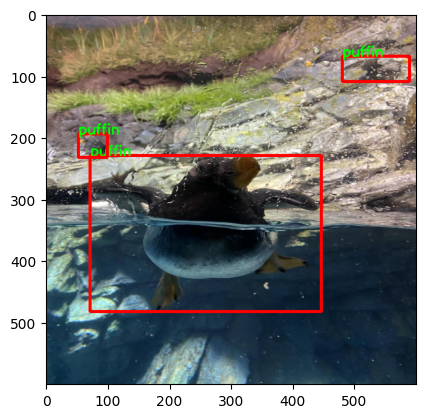

In [9]:
# Sample viewing code
def draw_bounding_boxes(image, boxes, labels, width=4):
    for box, label in zip(boxes, labels):
        pt1 = (int(box[0]), int(box[1]))
        pt2 = (int(box[2]), int(box[3]))
        image = cv2.rectangle(image, pt1, pt2, color=(255, 0, 0), thickness=width)
        image = cv2.putText(image, label, pt1, cv2.FONT_HERSHEY_SIMPLEX, 0.75, (0, 255, 0), 2)
    return image

# Lets view a sample
sample = train_dataset[2]
img_int = torch.tensor(sample[0] * 255, dtype=torch.uint8)
plt.imshow(draw_bounding_boxes(
    img_int.permute(1, 2, 0).numpy(),  # Permute to HWC format for OpenCV
    sample[1]['boxes'],
    [classes[i] for i in sample[1]['labels']],
    width=4
))
plt.show()

In [10]:
# Get the total number of samples in the training dataset
len(train_dataset)

447

## Load and Customize Faster R-CNN Model

In this section, we load a pre-trained Faster R-CNN model with a Resnet50 backbone. The model is then customized to fit the number of classes in our specific dataset by replacing the classification head.

In [12]:
# Load a pre-trained Faster R-CNN model with a ResNet-50 backbone
model = models.detection.fasterrcnn_resnet50_fpn(pretrained=___) # FIX ME

# Retrieve the number of input features for the classification head
in_features = model.roi_heads.box_predictor.cls_score.in_features

# Replace the original classification head with a new one tailored to our number of classes
# The new head will have 'n_classes' outputs, corresponding to the number of categories in our dataset
model.roi_heads.box_predictor = models.detection.faster_rcnn.FastRCNNPredictor(in_features, n_classes)

## Custom Collate Function

In this section, we define a custom `collate_fn` function for handling batch data in PyTorch's `DataLoader`. This function is used to correctly align and batch data and labels from the dataset.

In [13]:
# Define a custom collate function for data loading.
def collate_fn(batch):
    return tuple(zip(*batch))

## DataLoader Setup

In this section, we set up the `DataLoader` for our training dataset using the previously defined `collate_fn` function. This configuration helps in efficiently batching and shuffling data during training.

In [14]:
# Set up DataLoader for training data
train_loader = DataLoader(
    train_dataset,      # The dataset object to load data from
    batch_size=12,      # Number of samples per batch
    shuffle=True,       # Shuffle the data at every epoch
    num_workers=6,      # Number of worker processes for data loading
    collate_fn=collate_fn  # Custom collate function to handle batching
)

## Model Inference

In this section, we perform a forward pass through the model using a batch of data from the `train_loader`. This process involves extracting a batch of images and targets, converting them into the appropriate format, and passing them through the model.

In [15]:
# Extract a batch of images and targets from the DataLoader
images, targets = next(iter(train_loader))

# Convert images to a list (if required by the model)
images = list(image for image in images)

# Convert targets to a list of dictionaries (if required by the model)
targets = [{k: v for k, v in t.items()} for t in targets]

# Perform inference with the model
output = model(images, targets)  # Ensure this line runs without error

## Model Device Setup

In this section, we configure the model to use a GPU for training by moving it to the appropriate device. This setup is crucial for leveraging GPU acceleration, which can significantly speed up training and inference.

In [16]:
# Set the device to GPU
device = torch.device("cuda")  # Use GPU if available

# Move the model to the selected device
model = model.to(device)

## Optimizer Setup

In this section, we configure the optimizer for training the model. We use Stochastic Gradient Descent (SGD) with specific hyperparameters. Optionally, a learning rate scheduler can be included to adjust the learning rate during training.

In [17]:
# Select parameters of the model that require gradients
params = [p for p in model.parameters() if p.requires_grad]

# Initialize the optimizer with the selected parameters
optimizer = torch.optim.SGD(
    params,              # Parameters to optimize
    lr=0.01,             # Learning rate
    momentum=0.9,        # Momentum factor
    nesterov=True,       # Whether to use Nesterov momentum
    weight_decay=1e-4    # Weight decay (L2 regularization)
)

# Optionally, initialize a learning rate scheduler (commented out)
# lr_scheduler = torch.optim.lr_scheduler.MultiStepLR(
#     optimizer, 
#     milestones=[16, 22],  # Epochs at which to adjust the learning rate
#     gamma=0.1             # Factor by which to multiply the learning rate
# )

## Training One Epoch

This function trains the model for one epoch. It includes steps for forward and backward propagation, optimization, and loss tracking. Optionally, it supports learning rate warm-up and scheduling.

In [18]:
def train_one_epoch(model, optimizer, loader, device, epoch):
    """
    Train the model for one epoch.

    Args:
        model (torch.nn.Module): The model to train.
        optimizer (torch.optim.Optimizer): The optimizer for updating model parameters.
        loader (torch.utils.data.DataLoader): DataLoader for providing batches of data.
        device (torch.device): Device to run the model on (CPU or GPU).
        epoch (int): Current epoch number for tracking.

    Returns:
        None
    """
    # Move model to the specified device and set it to training mode
    model.to(device)
    model.train()

    # Optional: Learning rate warm-up (commented out)
    # if epoch == 0:
    #     warmup_factor = 1.0 / 1000  # Learning rate warm-up factor
    #     warmup_iters = min(1000, len(loader) - 1)
    #     lr_scheduler = torch.optim.lr_scheduler.LinearLR(optimizer, start_factor=warmup_factor, total_iters=warmup_iters)

    all_losses = []
    all_losses_dict = []

    for images, targets in tqdm(loader):
        # Move images and targets to the specified device
        images = list(image.to(device) for image in images)
        targets = [{k: torch.tensor(v).to(device) for k, v in t.items()} for t in targets]

        # Compute losses
        loss_dict = model(images, targets)  # Model computes the loss automatically
        losses = sum(loss for loss in loss_dict.values())
        loss_dict_append = {k: v.item() for k, v in loss_dict.items()}
        loss_value = losses.item()

        # Append loss values to track progress
        all_losses.append(loss_value)
        all_losses_dict.append(loss_dict_append)

        # Check for non-finite loss values and stop training if found
        if not math.isfinite(loss_value):
            print(f"Loss is {loss_value}, stopping training")  # Print loss details
            print(loss_dict)
            sys.exit(1)

        # Update model parameters
        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        # Optional: Step the learning rate scheduler (commented out)
        # if lr_scheduler is not None:
        #     lr_scheduler.step()

    # Convert loss dictionary to DataFrame for analysis
    all_losses_dict = pd.DataFrame(all_losses_dict)

    # Print out training statistics for the epoch
    print("Epoch {}, lr: {:.6f}, loss: {:.6f}, loss_classifier: {:.6f}, loss_box: {:.6f}, loss_rpn_box: {:.6f}, loss_object: {:.6f}".format(
        epoch, 
        optimizer.param_groups[0]['lr'],  # Current learning rate
        np.mean(all_losses),             # Average loss for the epoch
        all_losses_dict['loss_classifier'].mean(),  # Average classifier loss
        all_losses_dict['loss_box_reg'].mean(),     # Average box regression loss
        all_losses_dict['loss_rpn_box_reg'].mean(), # Average RPN box regression loss
        all_losses_dict['loss_objectness'].mean()   # Average objectness loss
    ))

## Training Loop

This section runs the training process for a specified number of epochs. Each epoch involves a complete pass over the training dataset, updating the model parameters based on the computed losses.

In [19]:
# Number of epochs for training
num_epochs = 10

# Training loop
for epoch in range(num_epochs):
    # Train the model for one epoch
    train_one_epoch(model, optimizer, train_loader, device, epoch)

    # Optional: Step the learning rate scheduler (commented out)
    # lr_scheduler.step()

100%|██████████| 38/38 [00:32<00:00,  1.17it/s]


Epoch 0, lr: 0.010000, loss: 1.058856, loss_classifier: 0.481928, loss_box: 0.404890, loss_rpn_box: 0.040827, loss_object: 0.131212


100%|██████████| 38/38 [00:30<00:00,  1.24it/s]


Epoch 1, lr: 0.010000, loss: 0.792757, loss_classifier: 0.367926, loss_box: 0.333883, loss_rpn_box: 0.034025, loss_object: 0.056923


100%|██████████| 38/38 [00:30<00:00,  1.25it/s]


Epoch 2, lr: 0.010000, loss: 0.692440, loss_classifier: 0.329770, loss_box: 0.290765, loss_rpn_box: 0.029301, loss_object: 0.042604


100%|██████████| 38/38 [00:13<00:00,  2.76it/s]


Epoch 3, lr: 0.010000, loss: 0.619852, loss_classifier: 0.281904, loss_box: 0.271517, loss_rpn_box: 0.027739, loss_object: 0.038693


100%|██████████| 38/38 [00:13<00:00,  2.78it/s]


Epoch 4, lr: 0.010000, loss: 0.561371, loss_classifier: 0.241484, loss_box: 0.261980, loss_rpn_box: 0.026596, loss_object: 0.031312


100%|██████████| 38/38 [00:13<00:00,  2.76it/s]


Epoch 5, lr: 0.010000, loss: 0.495927, loss_classifier: 0.201784, loss_box: 0.242942, loss_rpn_box: 0.024854, loss_object: 0.026347


100%|██████████| 38/38 [00:13<00:00,  2.75it/s]


Epoch 6, lr: 0.010000, loss: 0.466146, loss_classifier: 0.180492, loss_box: 0.239011, loss_rpn_box: 0.024560, loss_object: 0.022083


100%|██████████| 38/38 [00:13<00:00,  2.72it/s]


Epoch 7, lr: 0.010000, loss: 0.441787, loss_classifier: 0.170592, loss_box: 0.226514, loss_rpn_box: 0.024633, loss_object: 0.020047


100%|██████████| 38/38 [00:13<00:00,  2.76it/s]


Epoch 8, lr: 0.010000, loss: 0.423294, loss_classifier: 0.152382, loss_box: 0.228031, loss_rpn_box: 0.023330, loss_object: 0.019551


100%|██████████| 38/38 [00:13<00:00,  2.74it/s]

Epoch 9, lr: 0.010000, loss: 0.404819, loss_classifier: 0.145523, loss_box: 0.220326, loss_rpn_box: 0.021956, loss_object: 0.017014


In [20]:
# we will watch first epoch to ensure no errrors
# while it is training, lets write code to see the models predictions. lets try again
model.eval()
torch.cuda.empty_cache()

## Test Dataset Setup

In this section, we configure the dataset for testing. We initialize the `FishDataset` with the test split and apply transformations to the data.


In [21]:
# Initialize the test dataset
test_dataset = FishDataset(
    root=dataset_path,                # Path to the dataset
    split="test",                     # Specify the dataset split (test in this case)
    transforms=get_transforms(False)  # Apply transformations for testing
)

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


## Test Inference

In this section, we perform inference on a single test image. We load the image from the test dataset, preprocess it, and then pass it through the model to obtain predictions.

In [22]:
# Load a specific test image from the dataset
img, _ = test_dataset[5]

# Convert image to uint8 format for visualization
img_int = torch.tensor(img * 255, dtype=torch.uint8)

# Perform inference with the model
with torch.no_grad():
    # Move image to the appropriate device and perform prediction
    prediction = model([img.to(device)])
    pred = prediction[0]

## Visualizing Predictions with Bounding Boxes

In this section, we define a function to draw bounding boxes on an image and visualize the predictions made by the model. We use OpenCV for drawing and Matplotlib for displaying the image.

<class 'numpy.ndarray'>
(600, 600, 3)


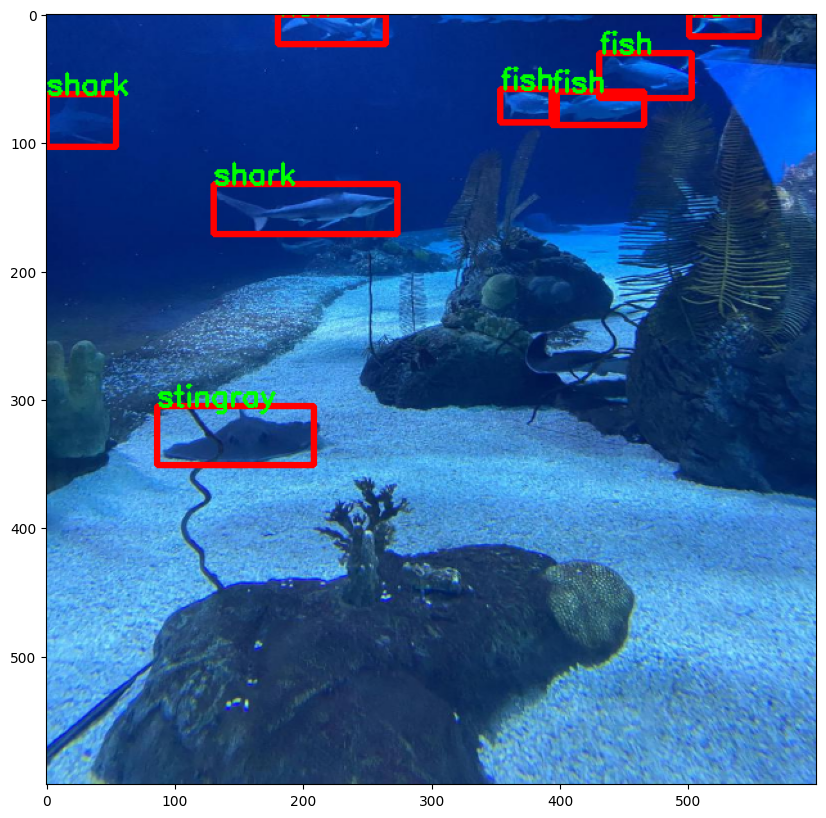

In [23]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Define the draw_bounding_boxes function
def draw_bounding_boxes(image, boxes, labels, width=4):
    image = image.copy()  # Make a copy of the image to avoid modifying the original
    for box, label in zip(boxes, labels):
        pt1 = (int(box[0]), int(box[1]))
        pt2 = (int(box[2]), int(box[3]))
        image = cv2.rectangle(image, pt1, pt2, color=(255, 0, 0), thickness=width)
        image = cv2.putText(image, label, pt1, cv2.FONT_HERSHEY_SIMPLEX, 0.75, (0, 255, 0), 2)
    return image

# Convert the tensor to a NumPy array
img_int = img.permute(1, 2, 0).cpu().numpy()  # Convert to HWC format
img_int = (img_int * 255).astype(np.uint8)  # Scale to 0-255 and convert to uint8

# Print the type and shape again to confirm
print(type(img_int))  # Should print <class 'numpy.ndarray'>
print(img_int.shape)  # Should print (600, 600, 3)

# Plot the image with bounding boxes
fig = plt.figure(figsize=(14, 10))
plt.imshow(draw_bounding_boxes(img_int, pred['boxes'][pred['scores'] > 0.8],
                               [classes[i] for i in pred['labels'][pred['scores'] > 0.8].tolist()], width=4))
plt.show()

## Saving the Model

In this section, we save the trained model to a file for future use. This allows you to reload the model later without needing to retrain it.


In [ ]:
import os
import torch

# Define the path where you want to save the model
model_save_path = os.path.expanduser("~/fasterrcnn_fish_detect_statedict.pth")

# Save the model
torch.save(model.state_dict(), model_save_path)
print(f"Model saved to {model_save_path}")